In [2]:
import pandas as pd
import numpy as np
# from IntrinsicProfiles_Functions import Analyse_Neuron
pd.set_option('display.max_rows', 200)

In [7]:
#!/usr/bin/env python
# coding: utf-8

import os  
import pandas as pd
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats, signal, optimize

def LoadFileABF_CC(filename, dualPatch=0):
    abf = pyabf.ABF(filename)
    #abf.headerLaunch()

    abf.setSweep(sweepNumber=0, channel=0)
    t = abf.sweepX
    sr = abf.dataRate
    V = np.empty((0,abf.sweepPointCount))
    I = np.empty((0,abf.sweepPointCount))
    
    firstChannel=0
    if dualPatch==2:
        firstChannel=2
        
    for sweep in range(abf.sweepCount):    
        abf.setSweep(sweepNumber=sweep, channel=firstChannel)
        V = np.vstack((V, abf.sweepY.reshape(1,-1)))
        abf.setSweep(sweepNumber=sweep, channel=firstChannel+1)
        I = np.vstack((I, abf.sweepY.reshape(1,-1)))

    return V, I, t, sr


def Analyse_IntrinsicProfile(V, I, t, sr, plotting=0):
    # Initialise output variables
    commandDuration = 0
    I_command = 0
    V_Ih = np.nan
    V_SS = np.nan
    AP_number = np.nan
    AP_firingFrequency = np.nan
    AP_threshold = np.nan
    AP_spikeHeight = np.nan
    AP_halfWidth = np.nan
    AP_fAHP = np.nan
    AP_adaptationIndexLast = np.nan 
    AP_adaptationIndexSecond = np.nan

    # Resting membrane potential
    RMP = np.median(V[0:int(0.05*sr)])    

    # Current command
    dI = np.insert(np.diff(I),0,0)
    I_peaks,_ = signal.find_peaks(dI,height=3)

    if np.shape(I_peaks)[0]:
        I_ON = np.argmax(dI)
        I_OFF = np.argmin(dI)
        if I_ON > I_OFF: # Negative current steps
            I_OFF = np.argmax(dI)
            I_ON = np.argmin(dI)

        commandDuration=t[I_OFF]-t[I_ON]
        I_command=np.round(np.mean(I[I_ON+int(0.1*sr):I_ON+int(0.2*sr)])-np.mean(I[I_ON-int(0.2*sr):I_ON-int(0.1*sr)]))

        if I_command < 0: #Hyperpolarizing current steps

            # Hyperpolarization-induced voltage sag
            V_Inst_idx = np.argmin(V[I_ON:I_OFF])+I_ON
            V_Inst = V[V_Inst_idx]
            V_SS = np.mean(V[I_OFF-int(0.05*sr):I_OFF])
            V_Ih = V_SS - V_Inst

        else: # Depolarising current steps

            #Firing frequency: number action potentials (APs)
            V_peaks, _ = signal.find_peaks(V[I_ON:I_OFF],height=0,prominence=10)          
            AP_number = np.shape(V_peaks)[0]
            AP_firingFrequency = AP_number/commandDuration

            #Find firing frequency adaptation
            if np.shape(V_peaks)[0] >= 3:

                #Simon's method
                adaptationWindow = 0.1
                spikeN_i = np.count_nonzero((V_peaks) < adaptationWindow*sr)
                spikeN_f = np.count_nonzero(((V_peaks) > (commandDuration-adaptationWindow)*sr) & ((V_peaks) < commandDuration*sr))
                if spikeN_i != 0:
                    AP_adaptationIndexLast = (spikeN_i-spikeN_f)/spikeN_i*100

                # Scala et al., 2020 method: ratio between second inter-spike interval and first interspike interval
                AP_adaptationIndexSecond = (V_peaks[2]-V_peaks[1])/(V_peaks[1]-V_peaks[0])


            if np.shape(V_peaks)[0] in [1,2,3]:

                # Action potential features
                V_peaks = V_peaks + I_ON
                if np.shape(V_peaks)[0] in [2,3]:
                    end_idx = (V_peaks)[1]
                else:
                    end_idx = I_OFF   
                    
                AP_window = np.arange(V_peaks[0]-int(0.03*sr),end_idx)
                AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Spike(V[AP_window], t[AP_window], sr, int(0.03*sr), plotting)

    return [commandDuration, I_command, RMP, V_SS, V_Ih, AP_number, AP_firingFrequency, AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP, AP_adaptationIndexLast, AP_adaptationIndexSecond]


# In[4]:


def Analyse_Spike(V, t, sr, spikeIdx, plotting=0):
    # AP threshold: first derivative method, 10mV/ms cut-off
    thresholdCutOff = 10 #mV/ms
    dV = np.insert(np.diff(V,n=1),0,0)
    dV_peaks, _ = signal.find_peaks(dV,height=0.7)
    
    dV=dV*(sr/10**3) # Convert to mv/ms
    Th_idx = np.argmin(np.array(abs(dV[:dV_peaks[0]]-thresholdCutOff)))
    AP_threshold = V[Th_idx]

    #  AP height
    AP_peakHeight = V[spikeIdx]
    AP_spikeHeight = AP_peakHeight-AP_threshold

    # AP half-width
    AP_halfHeigth = AP_spikeHeight/2
    endIdx = spikeIdx+int(0.007*sr)
    Half_Start = np.argmin(np.array(abs(V[Th_idx:spikeIdx]-(AP_peakHeight-AP_halfHeigth))))+Th_idx
    Half_End = np.argmin(np.array(abs(V[spikeIdx:endIdx]-(AP_peakHeight-AP_halfHeigth))))+spikeIdx
    AP_halfWidth = t[Half_End]-t[Half_Start]

    # Fast AHP (fAHP) amplitude
    fAHP_idx = np.argmin(V[spikeIdx:endIdx])+spikeIdx
    AP_fAHP = AP_threshold - V[fAHP_idx]

    #Plot AP and points of interest
    if plotting:
        plt.figure()
        plt.plot(t,V)
        plt.plot(t[spikeIdx],V[spikeIdx],'rx')
        plt.plot(t[Th_idx],V[Th_idx],'bx')
        plt.plot(t[Half_Start],V[Half_Start],'bx')
        plt.plot(t[Half_End],V[Half_End],'bx')
        plt.plot(t[fAHP_idx],V[fAHP_idx],'bx')              

    return(AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP)


# In[5]:


def Analyse_Tau(V, I, t, sr, plotting=0):
    #Start-end current command
    dI = np.insert(np.diff(I),0,0)
    I_peaks,_ = signal.find_peaks(dI,height=5)
    assert np.shape(I_peaks)[0]
    I_OFF = np.argmax(dI)
    I_ON = np.argmin(dI)

    # Decay time constant
    def mono_exp(x, a, b):
        return a * np.exp(b * x)

    xfit = t[I_ON:I_OFF]
    yfit = V[I_ON:I_OFF]-np.mean(V[I_OFF-int(0.005*sr):I_OFF])
    popt,pcov = optimize.curve_fit(mono_exp, xfit, yfit, method = 'lm', p0=(1.0,1.0), maxfev = 15000)
    Tau = 1/(-popt[1])     
    
    #Plot tau fitting
    if plotting:
        interpolX=t[I_ON-int(0.02*sr):I_OFF]
        plt.figure()
        plt.plot(xfit, yfit, 'k', label="Data")
        plt.plot(interpolX, mono_exp(interpolX, *popt), 'r-', label="Fitted Curve")            
        plt.legend()
        plt.show()

    return Tau


# In[6]:


def Analyse_Neuron(neuron, plotting=0):
    # Initialise dataframe for single cell data 
    cols=['CurrentDuration','CurrentAmplitude','RMP','VoltageSteadyState','VoltageSag','ActionPotentialNumber','FiringFrequency','SpikeThreshold','SpikeHeight','SpikeHalfWidth','SpikeAHP','AdaptationIndexLast','AdaptationIndexSecond']
    neuronResults=pd.DataFrame(columns=cols)

    #### Obtain data
    for i, filename in enumerate(neuron.filename):
        if i == 0:
            neuron.reset_index(inplace=True, drop=True)

        if neuron.Experiment[i]=='IntrinsicProfile':  
            print("Analysing"+filename)
            V, I, t, sr = LoadFileABF_CC(neuron.foldername[i]+"\\"+neuron.CellID[i]+"\\"+filename, neuron.DualPatch[0])

            for sweep in range(V.shape[0]):
                neuronResults.loc[len(neuronResults), :] = Analyse_IntrinsicProfile(V[sweep,:], I[sweep,:], t, sr, plotting)
    
    #### Save all data
    neuronResults[cols] = neuronResults[cols].astype(float)
    outputFolder = os.path.join(neuron.foldername[0],neuron.CellID[0],'IntrinsicProfile')
    if not os.path.isdir(outputFolder):
        os.mkdir(outputFolder)
    neuronResults.to_csv(os.path.join(outputFolder,neuron.CellID[0]+'.csv'), index=False)
    
    ##### Calculate features
#     # Select only multiples of 10 pA current steps
#     def myround(x, base=5):
#         return  np.round(x/base)*base
#     neuronResults.CurrentAmplitude = myround(neuronResults.CurrentAmplitude.to_numpy(dtype=float), 5)
#     neuronResults = neuronResults[neuronResults.CurrentAmplitude%10==0]
    
    # dv/dT vs V 
    indexdV = np.nanargmin(np.array((abs(neuronResults.ActionPotentialNumber-10))))
    
    # Tau        
    hyperpolarisingStepsIdx = np.array(neuronResults[(neuronResults.CurrentAmplitude >= -200)&(neuronResults.CurrentAmplitude < 0)].index, dtype=int)
#     medianV = np.median(V[hyperpolarisingStepsIdx,:],0)
    medianV = V[hyperpolarisingStepsIdx[-1],:]
    Tau = Analyse_Tau(medianV, I[0,:], t, sr, plotting)
    
    # Firing
    MaxFiringFrequency = neuronResults.FiringFrequency.max()
    AdaptationIndex = neuronResults[neuronResults.ActionPotentialNumber >= 3].AdaptationIndexSecond[:5].median()

    # RMP and Rin
    xH = np.array(neuronResults[(neuronResults.CurrentAmplitude >= -200)&(neuronResults.CurrentAmplitude < 0)].CurrentAmplitude, dtype=float)
    yH = np.array(neuronResults[(neuronResults.CurrentAmplitude >= -200)&(neuronResults.CurrentAmplitude < 0)].VoltageSteadyState, dtype=float)

    slope, intercept = np.polyfit(xH, yH, 1)
    xHfit = np.arange(-150, 50, 10)
    yHfit = slope*xHfit + intercept
    
    Rin = slope*1000 # MOhm
    RMP = intercept # mV
            
    # Rheobase
    xD = np.array(neuronResults[neuronResults.ActionPotentialNumber > 0].CurrentAmplitude[0:5], dtype=float)
    yD = np.array(neuronResults[neuronResults.ActionPotentialNumber > 0].FiringFrequency[0:5], dtype=float)

    slope, intercept = np.polyfit(xD, yD, 1)
    xDfit = np.arange(10, max(xD), 10)
    yDfit = slope*xDfit + intercept
    
    Rheobase = -intercept/slope #pA            
    if (Rheobase < 5) | (Rheobase > 3000):
        Rheobase = xD[0]
    
    # Voltage sag
    VoltageSag = neuronResults.VoltageSag[0]

    # Spike features
    AP_Threshold = neuronResults[~neuronResults.SpikeThreshold.isnull()].SpikeThreshold.iloc[0]
    AP_Height = neuronResults[~neuronResults.SpikeThreshold.isnull()].SpikeHeight.iloc[0]
    AP_HalfWidth = neuronResults[~neuronResults.SpikeThreshold.isnull()].SpikeHalfWidth.iloc[0]
    AP_AHP = neuronResults[~neuronResults.SpikeThreshold.isnull()].SpikeAHP.iloc[0]               
    
    #### Make figure
    singleSpikeIdx = neuronResults[neuronResults.ActionPotentialNumber>0].ActionPotentialNumber.idxmin()
    maxSpikeIdx = neuronResults.FiringFrequency.idxmax()
    sagIdx = (neuronResults.VoltageSteadyState+100).idxmin()

    fig = plt.figure(figsize=[20, 20])
    gs = gridspec.GridSpec(7, 2)
    plt.suptitle(neuron.CellID[0] + ' - ' + neuron.CellTarget[0]+'-'+neuron.CellType[0], fontsize=30)
    
    ax1 = plt.subplot(gs[0:3, 0])
    ax1.plot(t,V[maxSpikeIdx,:],'k')
    ax1.set_xlim((1, 1.8))
    ax1.set_ylim((-110, 30))
    plt.axis('off')

    ax2 = plt.subplot(gs[3:6, 0])
    ax2.plot(t,V[singleSpikeIdx,:],'k')
    ax2.plot(t,V[sagIdx,:],'k')
    ax2.plot((1.6, 1.8), (0, 0),'k', linewidth=3)
    ax2.plot((1.6, 1.6), (0, 30),'k', linewidth=3)
    plt.text(1.61, 13, '30 mV', fontsize=20)
    plt.text(1.64, -8, '200 ms', fontsize=20)

    ax2.set_xlim((1, 1.8))
    ax2.set_ylim((-110, 30))
    plt.axis('off')

    ax3 = plt.subplot(gs[6, 0])
    ax3.plot(t, I[singleSpikeIdx,:],'k')
    ax3.plot(t, I[sagIdx,:],'k')
    ax3.plot(t, I[maxSpikeIdx,:],'k')
    ax3.set_xlim((1, 1.7))
    plt.axis('off')

    ax4 = plt.subplot(gs[0:4, 1])
    ax4.plot(neuronResults[neuronResults.CurrentAmplitude>=0].CurrentAmplitude, neuronResults[neuronResults.CurrentAmplitude>=0].FiringFrequency, 'ko')
    ax4.set_xlabel('Current (pA)', fontsize=20)
    ax4.set_ylim((0, neuronResults.FiringFrequency.max()+5))
    ax4.set_ylabel('Firing Frequency (Hz)', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=20)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_linewidth(3)
    ax4.spines['bottom'].set_linewidth(3)
    ax4.xaxis.set_tick_params(width=3, length=10)
    ax4.yaxis.set_tick_params(width=3, length=10)
    plt.text(50,1,'RMP='+str(RMP.round())+' mV\nRin='+str(Rin.round())+' MOhm\nRheobase='+str(Rheobase.round())+' pA',fontsize = 20)

    
    ax5 = plt.subplot(gs[4:,1])
    ax5.plot(V[indexdV,:], np.diff(V[indexdV,:], prepend = V[indexdV,0] ), 'k-')
    ax5.set_ylabel('dV/dt', fontsize=20)
    ax5.set_xlabel('Voltage (mV)', fontsize=20)
    ax5.spines['left'].set_linewidth(3)
    ax5.spines['bottom'].set_linewidth(3)
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    ax5.xaxis.set_tick_params(width=3, length=10)
    ax5.yaxis.set_tick_params(width=3, length=10)
    ax5.tick_params(axis='both', which='major', labelsize=20)
    ax5.tick_params(axis='y')
    

#     #### Rin and RMP plot
#     ax5 = plt.subplot(gs[4:,1])
#     ax5.plot(xH, yH, 'ro')
#     ax5.plot(xHfit, yHfit, 'k--')
#     ax5.plot([0, 0], [-500, 500], 'k', linewidth=0.5)
#     ax5.set_ylabel('Steady-state Vm (mV)', fontsize=20, color='r')
#     ax5.set_xlabel('Current (pA)', fontsize=20)
#     ax5.spines['left'].set_linewidth(3)
#     ax5.spines['bottom'].set_linewidth(3)
#     ax5.spines['top'].set_visible(False)
#     ax5.xaxis.set_tick_params(width=3, length=10)
#     ax5.yaxis.set_tick_params(width=3, length=10)
#     ax5.tick_params(axis='both', which='major', labelsize=20)
#     ax5.tick_params(axis='y', labelcolor='r')
#     ax5.set_ylim((yH.min(), yH.max()+10))
    
#     ax6 = ax5.twinx()  # instantiate a second axes that shares the same x-axis
#     ax6.plot(xD, yD, 'bo')
#     ax6.plot(xDfit, yDfit, 'k--')
#     ax6.plot([-500, 500], [0, 0], 'k', linewidth=0.5)
#     ax6.set_ylabel('Firing Frequency (Hz)', fontsize=20, color='b')
#     ax6.spines['right'].set_linewidth(3)
#     ax6.spines['top'].set_visible(False)
#     ax6.xaxis.set_tick_params(width=3, length=10)
#     ax6.yaxis.set_tick_params(width=3, length=10)
#     ax6.tick_params(axis='both', which='major', labelsize=20)
#     ax6.tick_params(axis='y', labelcolor='b')
#     ax6.set_xlim((-100, xD.max()+5))
#     ax6.set_ylim((-1, yD.max()+2))
    
    gs.update(hspace = 0.5, wspace =0.2)

    plt.savefig(os.path.join(outputFolder,neuron.CellID[0]+'.pdf'), format='pdf', transparent=True)
    plt.savefig(os.path.join(outputFolder,neuron.CellID[0]+'.tif'), format='tif', transparent=True)
    plt.close()
    
    #### Make output
    if neuron.MouseEyesOpen[0] == 1:
        Development = 'P14-P18'
    else:
        if neuron.MouseAge[0] <= 8:
            Development = 'P5-P8'
        elif (neuron.MouseAge[0] >= 9) & (neuron.MouseAge[0] <= 13):
            Development = 'P9-P13'
    
    results = [neuron.CellID[0], neuron.MouseAge[0], Development, neuron.BrainArea[0], neuron.CellTarget[0], neuron.CellType[0], neuron.CellLayer[0], RMP, Rin, Tau, Rheobase, AP_Threshold, AP_Height, AP_HalfWidth, AP_AHP, MaxFiringFrequency, AdaptationIndex, VoltageSag]

    return results



In [8]:
def loadLabBook(filename):
    data = pd.read_csv(filename)
    data["filename"] =  data["filename"].apply(lambda x: x if x.endswith(".abf") else x+".abf")
    data.to_csv(filename, index = False)
    return data

MJ15.1
Analysing20n02001.abf


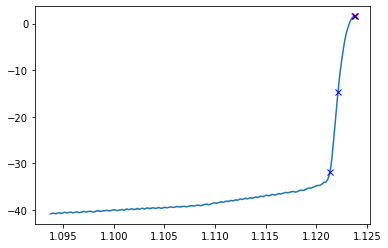

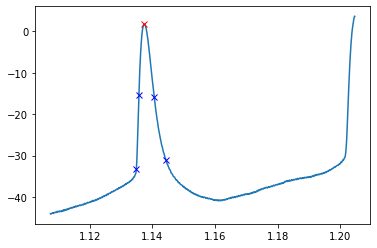

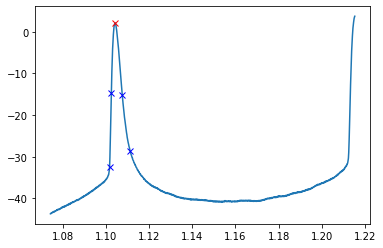

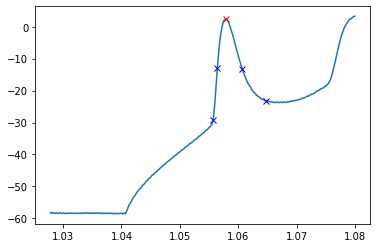

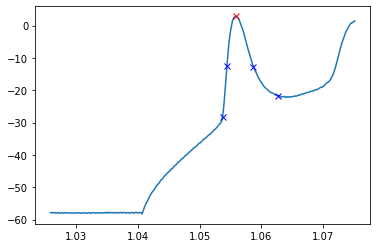

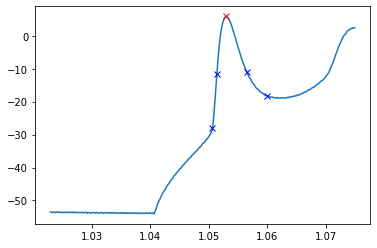

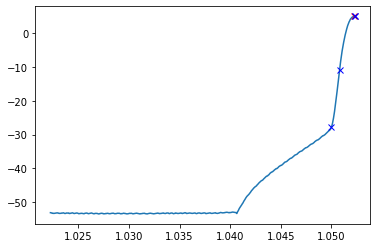

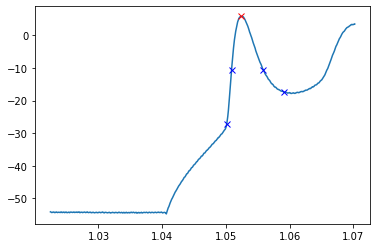

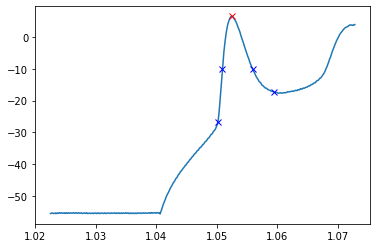

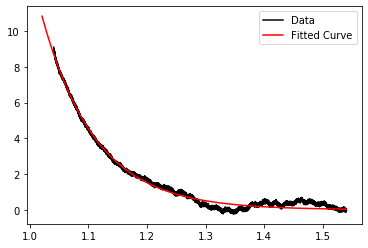

In [11]:
# Inputs
filename = "C:\\Users\\Butt Lab\\OneDrive - OnTheHub - The University of Oxford\\TheBible.csv"
data = loadLabBook(filename)
data = data[data.Experiment=='IntrinsicProfile']
data = data[data.Discard==0]

# Select IDs to analyse
cellIDs=np.unique(data.CellID)
cellIDs=["MJ15.1"]

#Initialize results dataframe
resultsColumns = ['Cell_ID','Age','Development','BrainArea','CellTarget','CellType','CellLayer','RMP','Rin','Tau','Rheobase','AP_Threshold','AP_Height','AP_HalfWidth','AP_AHP','MaxFiringFrequency','AdaptationIndex','VoltageSag']
results = pd.DataFrame(columns=resultsColumns)
for cellID in cellIDs:
    print(cellID)
    neuron=data[data.CellID==cellID]    
    results.loc[len(results), :] = Analyse_Neuron(neuron, plotting=True)
results.to_csv('IntrinsicProfiles_Results.csv')

In [10]:
results

,Cell_ID,Age,Development,BrainArea,CellTarget,CellType,CellLayer,RMP,Rin,Tau,Rheobase,AP_Threshold,AP_Height,AP_HalfWidth,AP_AHP,MaxFiringFrequency,AdaptationIndex,VoltageSag
0,MJ15.1,6,P5-P8,V1,Pyramidal,Pyr,23,-62.2777,1458.91,0.0911321,10,-31.7688,33.3557,0.00165,-33.3252,30,2,3.18109


In [30]:
results.groupby(["BrainArea","Development","CellType","CellLayer"])["Cell_ID"].count()

BrainArea  Development  CellType  CellLayer
S1BF       P14-P18      FS        4.0           1
                        PV        4.0          10
                        Pyr       4.0          10
                        SST       4.0           5
                                  5.0           2
           P5-P8        FS        4.0           1
                        PV        4.0           2
                                  5.0           1
                                  23.0          1
                        Pyr       4.0           8
                        SST       4.0           8
                                  5.0           2
                                  23.0          1
           P9-P13       PV        4.0           5
                                  5.0           1
                        Pyr       4.0          10
                        SST       4.0           5
V1         P14-P18      FS        4.0           2
                        NGF       4.0           1
      

(0, 0.005)

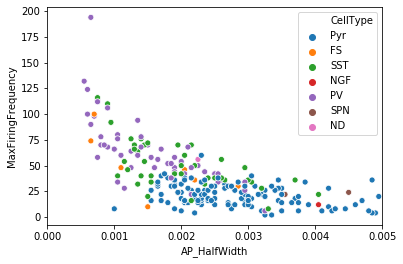

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure
sns.scatterplot(x='AP_HalfWidth', y='MaxFiringFrequency', hue='CellType',data=results)
plt.xlim(0, 0.005)

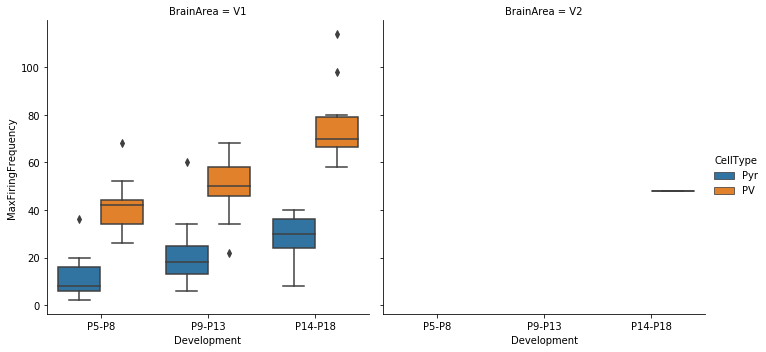

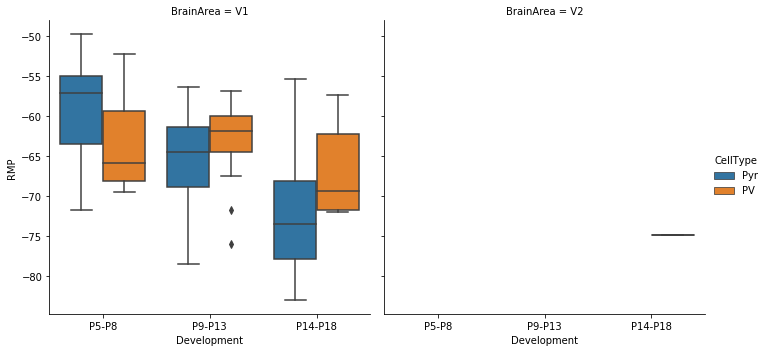

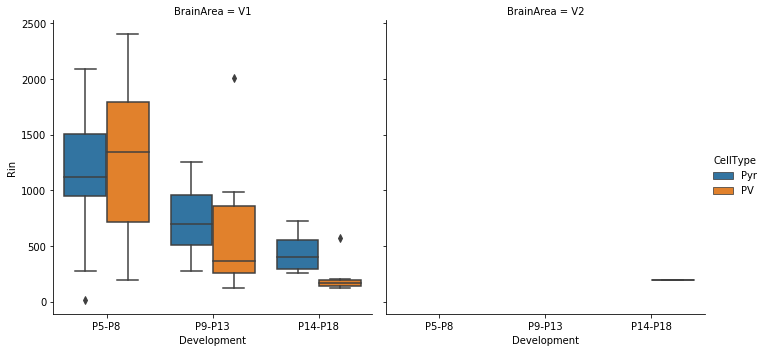

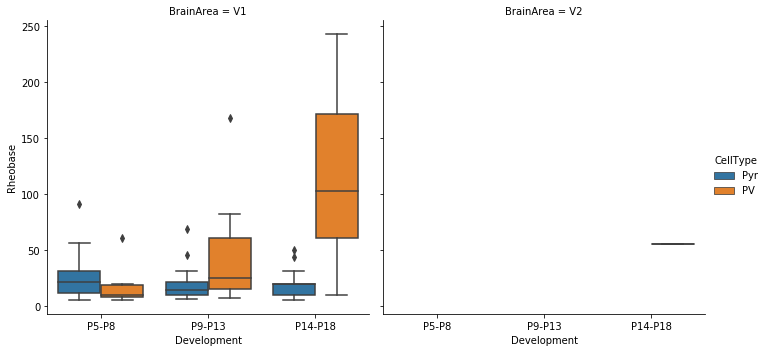

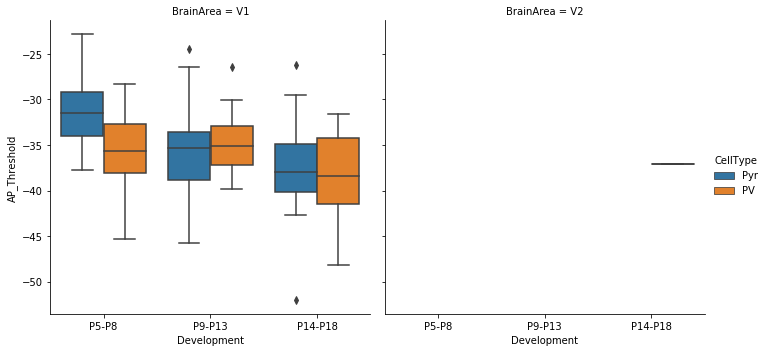

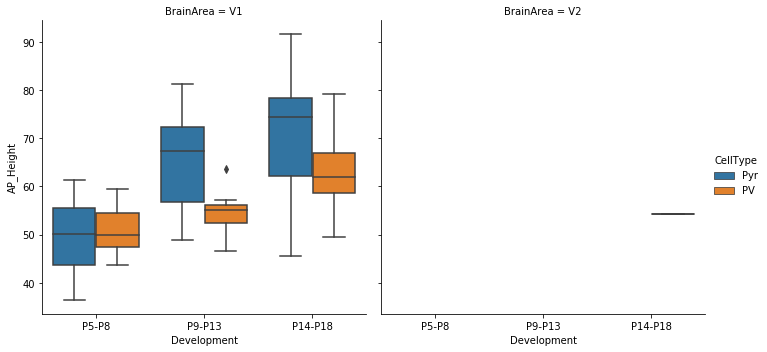

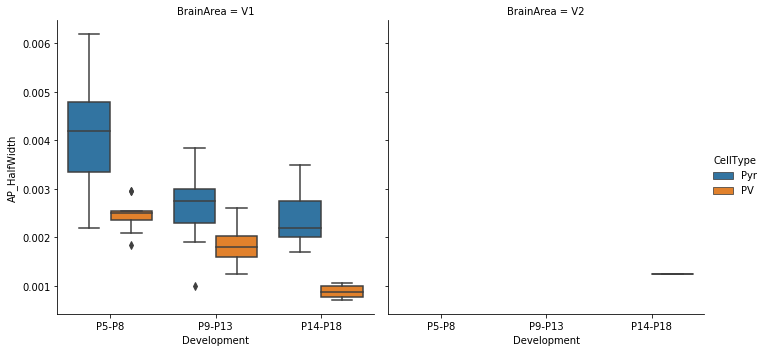

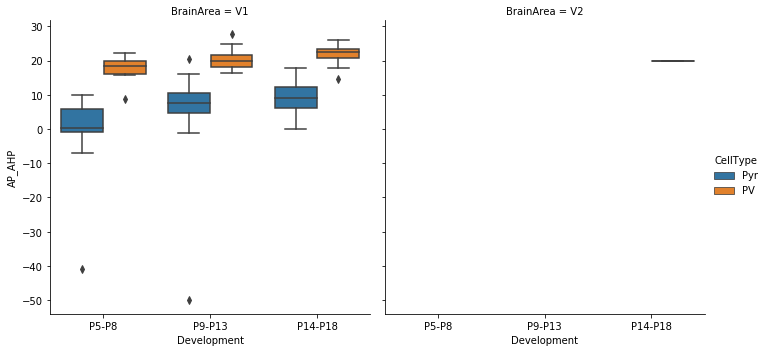

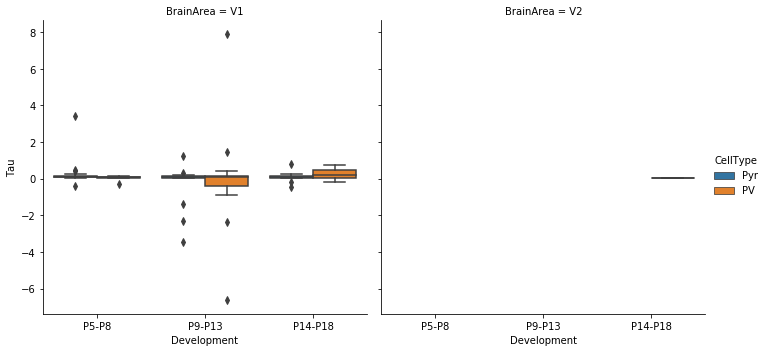

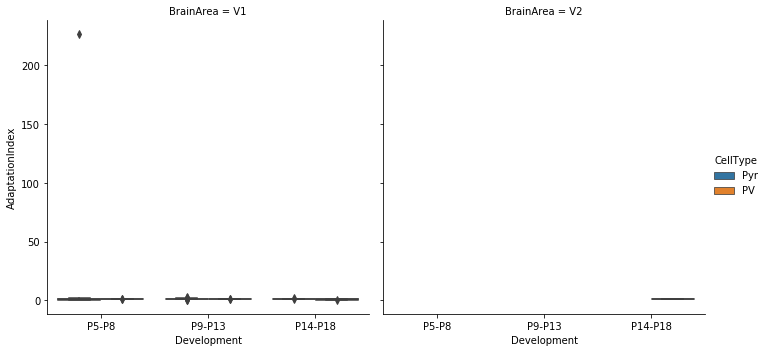

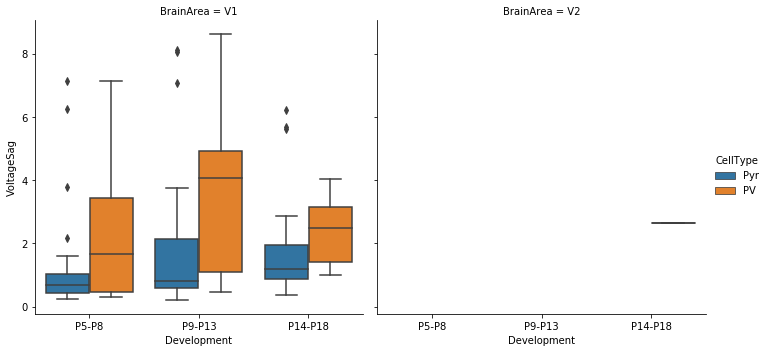

In [9]:
resultsPlotting=results[(results.CellType!='FS')&(results.CellType!='NGF')&(results.CellType!='SST')&(results.CellType!='ND')&(results.BrainArea!='S1BF')&(results.CellLayer==4)]

g = sns.catplot(x="Development", y="MaxFiringFrequency", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="RMP", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="Rin", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="Rheobase", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="AP_Threshold", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="AP_Height", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="AP_HalfWidth", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="AP_AHP", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="Tau", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="AdaptationIndex", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);
g = sns.catplot(x="Development", y="VoltageSag", hue="CellType", col='BrainArea', order=['P5-P8','P9-P13','P14-P18'], data=resultsPlotting, kind="box",height=5, aspect=1);

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

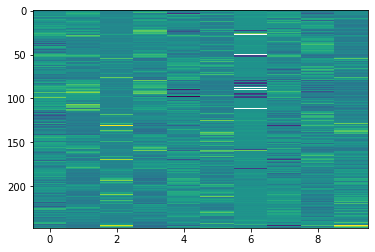

In [10]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

## Do tSNE
results2=results.drop([35])
for col in ['RMP', 'Rin', 'Tau','Rheobase','AP_Threshold', 'AP_Height', 'AP_HalfWidth', 'AP_AHP', 'MaxFiringFrequency', 'AdaptationIndex', 'VoltageSag']:
    results2[col] = results2[col].astype(float)
results2["LogAdaptationIndex"] = np.log(results2.AdaptationIndex)
data = results2[['RMP', 'Rin', 'Rheobase' , 'AP_HalfWidth', 'AP_AHP','VoltageSag', 'LogAdaptationIndex', 'AP_Threshold', 'AP_Height', 'MaxFiringFrequency']].to_numpy(dtype=float)#'Tau', 
z_data = StandardScaler().fit_transform(data)
plt.imshow(z_data, aspect='auto')

## tSNE plot
X_embedded = TSNE(perplexity = 6, method = 'exact').fit_transform(z_data)
#perplexity = 15, method = 'exact', random_state = 42
plt.figure(figsize=(20,12))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue="CellType", data=results2, legend="full", s=100)

## tSNE plot by cell type
results2["tSNE1"] = X_embedded[:,0]
results2["tSNE2"] = X_embedded[:,1]
plt.figure(figsize=(20,12))
g = sns.FacetGrid(results2, hue="Development", col="CellType", legend_out=True)
g = g.map(plt.scatter, "tSNE1", "tSNE2",  s=100).add_legend()